In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import regularizers
from sklearn.neural_network import BernoulliRBM
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from keras import layers
import pandas as pd
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


流式输出内容被截断，只能显示最后 5000 行内容。
[BernoulliRBM] Iteration 608, pseudo-likelihood = -83.13, time = 0.02s
[BernoulliRBM] Iteration 609, pseudo-likelihood = -83.68, time = 0.02s
[BernoulliRBM] Iteration 610, pseudo-likelihood = -83.09, time = 0.03s
[BernoulliRBM] Iteration 611, pseudo-likelihood = -83.18, time = 0.02s
[BernoulliRBM] Iteration 612, pseudo-likelihood = -83.72, time = 0.02s
[BernoulliRBM] Iteration 613, pseudo-likelihood = -83.21, time = 0.02s
[BernoulliRBM] Iteration 614, pseudo-likelihood = -82.95, time = 0.02s
[BernoulliRBM] Iteration 615, pseudo-likelihood = -83.01, time = 0.02s
[BernoulliRBM] Iteration 616, pseudo-likelihood = -82.89, time = 0.02s
[BernoulliRBM] Iteration 617, pseudo-likelihood = -83.35, time = 0.02s
[BernoulliRBM] Iteration 618, pseudo-likelihood = -83.03, time = 0.02s
[BernoulliRBM] Iteration 619, pseudo-likelihood = -83.26, time = 0.02s
[BernoulliRBM] Iteration 620, pseudo-likelihood = -82.98, time = 0.03s
[BernoulliRBM] Iteration 621, pseudo-likelihood = 

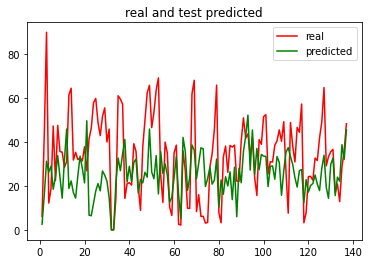

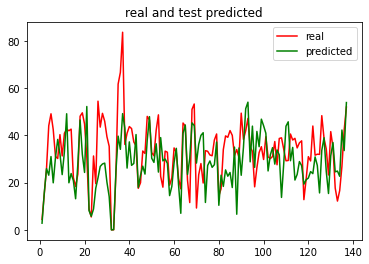

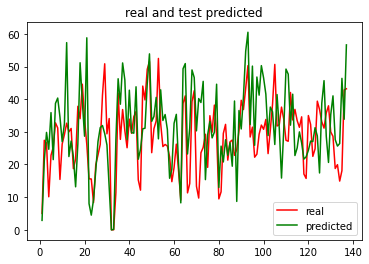

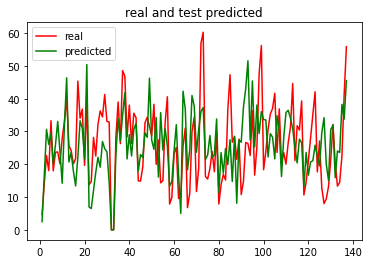

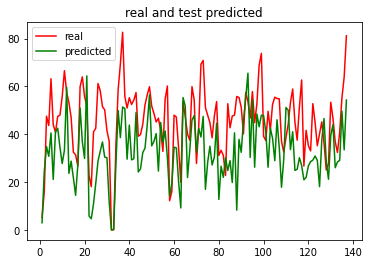

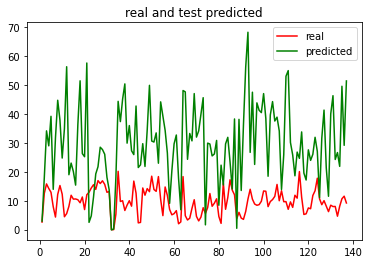

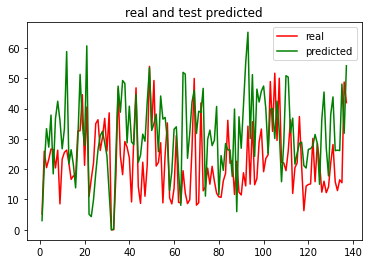

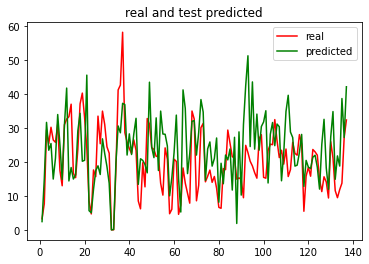

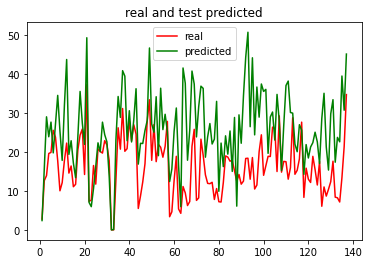

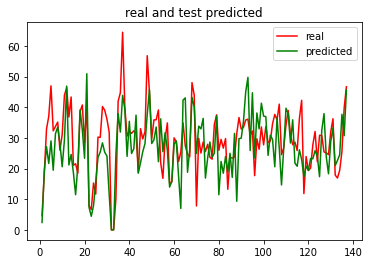

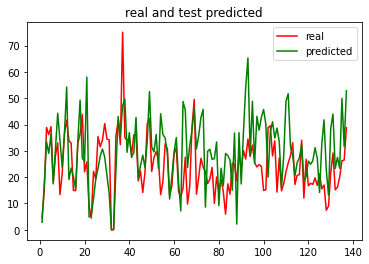

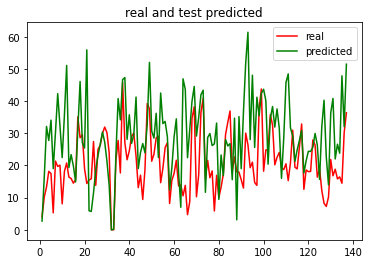

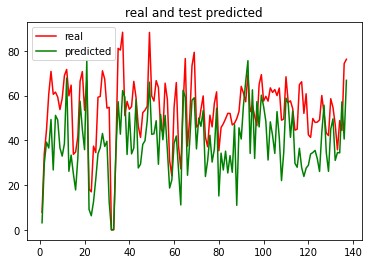

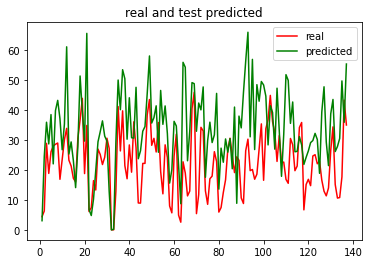

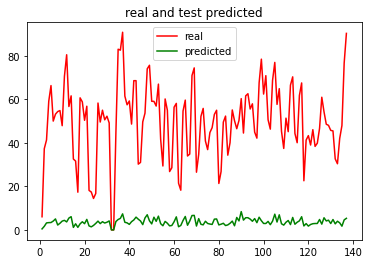

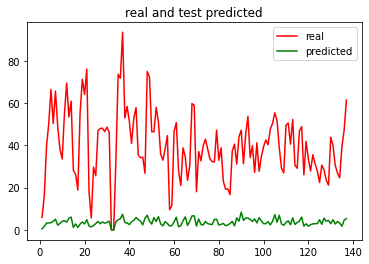

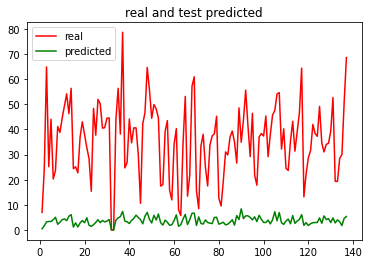

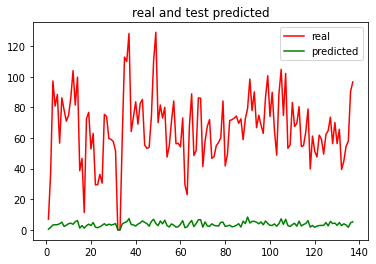

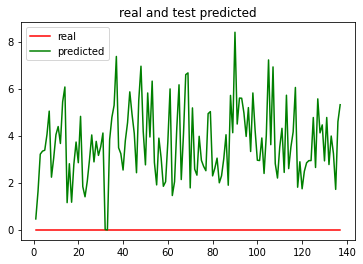

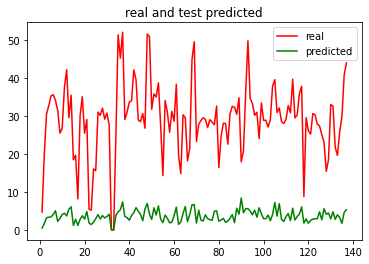

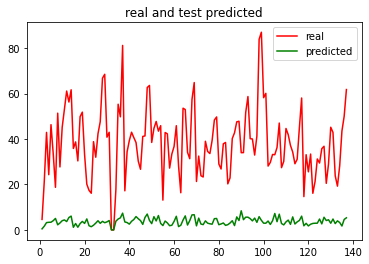

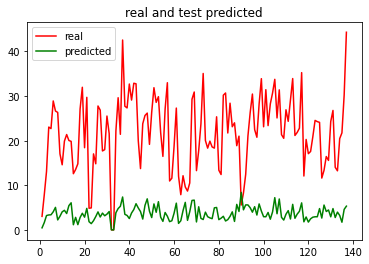

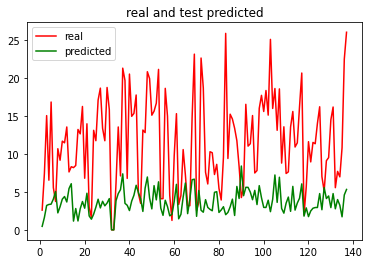

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
class DBN():
    def __init__(
            self,
            x_train,
            y_train,
            x_test,
            y_test,
            hidden_layer,
            learning_rate_rbm=0.002,
            batch_size_rbm=1,
            n_epochs_rbm=2000,
            verbose_rbm=1,
            random_seed_rbm=1300,
            activation_function_nn='relu',
            learning_rate_nn=0.002,
            batch_size_nn=10,
            n_epochs_nn=800,
            verbose_nn=1,
            decay_rate=0):

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.hidden_layer = hidden_layer
        self.learning_rate_rbm = learning_rate_rbm
        self.batch_size_rbm = batch_size_rbm
        self.n_epochs_rbm = n_epochs_rbm
        self.verbose_rbm = verbose_rbm
        self.random_seed = random_seed_rbm
        self.activation_function_nn = activation_function_nn
        self.learning_rate_nn = learning_rate_nn
        self.batch_size_nn = batch_size_nn
        self.n_epochs_nn = n_epochs_nn
        self.verbose_nn = verbose_nn
        self.decay_rate = decay_rate
        self.weight_rbm = []
        self.bias_rbm = []
        self.test_rms = 0
        self.result = []
        self.model = Sequential()

    def pretraining(self):
        input_layer = self.x_train
        for i in range(len(self.hidden_layer)):
            print("DBN Layer {0} Pre-training".format(i + 1))
            rbm = BernoulliRBM(n_components=self.hidden_layer[i],
                               learning_rate=self.learning_rate_rbm,
                               batch_size=self.batch_size_rbm,
                               n_iter=self.n_epochs_rbm,
                               verbose=self.verbose_rbm,
                               random_state=self.verbose_rbm)
            rbm.fit(input_layer)
            # size of weight matrix is [input_layer, hidden_layer]
            self.weight_rbm.append(rbm.components_.T)
            self.bias_rbm.append(rbm.intercept_hidden_)
            input_layer = rbm.transform(input_layer)
        print('Pre-training finish.')

    def finetuning(self):
        print('Fine-tuning start.')

        for i in range(0, len(self.hidden_layer)):
            if i == 0:
                self.model.add(Dense(self.hidden_layer[i], activation=self.activation_function_nn,
                                     input_dim=self.x_train.shape[1]))
            elif i >= 1:
                self.model.add(Dense(self.hidden_layer[i], activation=self.activation_function_nn))
            else:
                pass
            layer = self.model.layers[i]
            layer.set_weights([self.weight_rbm[i], self.bias_rbm[i]])
        print(self.y_train.shape[1])
        if (self.y_train.ndim == 1):
            self.model.add(Dense(1, activation=None, kernel_regularizer=regularizers.l2(0.01)))
        else:
            self.model.add(Dense(70, activation='relu'))
            #self.model.add(layers.Dropout(0.4))
            self.model.add(Dense(100, activation='relu'))
            self.model.add(Dense(120, activation='relu'))
            self.model.add(Dense(140, activation='relu'))
            self.model.add(Dense(160, activation='relu'))

            self.model.add(Dense(self.y_train.shape[1], activation=None))

        sgd = SGD(lr=self.learning_rate_nn, decay=self.decay_rate)
        self.model.compile(loss='mse',
                           optimizer=sgd,
                           )
        history=self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size_nn,
                       epochs=self.n_epochs_nn, verbose=self.verbose_nn)
        print('Fine-tuning finish.')
        self.test_rms = self.model.evaluate(self.x_test, self.y_test)
        self.result = np.array(self.model.predict(self.x_test))


    def predict(self, series):
        return np.array(self.model.predict(series))

def datagen(path1,path2,path3,path4):
    Data,label, Test,testlabel= [],[],[],[]
    Data1,labels,Test1,testlabel1 = [],[],[],[]

    with open(path1, 'r', encoding='gb18030', errors='ignore') as f1:
        csv_reader1 = csv.reader(f1)
        for row in csv_reader1:
            Data.append(row)
    with open(path2, 'r', encoding='gb18030', errors='ignore') as f2:
        csv_reader2 = csv.reader(f2)
        for row in csv_reader2:
            label.append(row)
    with open(path3, 'r', encoding='gb18030', errors='ignore') as f3:
        csv_reader3 = csv.reader(f3)
        for row in csv_reader3:
            Test.append(row)
    with open(path4, 'r', encoding='gb18030', errors='ignore') as f4:
        csv_reader4 = csv.reader(f4)
        for row in csv_reader4:
            testlabel.append(row)

    #mix the dataset
    idx = np.random.randint(1, len(Data), len(Data)-1)
    for i in range(len(idx)):
        ax = Data[idx[i]][:]
        bx = label[idx[i]][:]
        Data1.append(ax)
        labels.append(bx)

    for i in range(1,len(Test)-1):
        cx = Test[i][:]
        dx = testlabel[i][:]
        Test1.append(cx)
        testlabel1.append(dx)

    X = np.empty((len(Data1), 141), dtype=np.float32)
    Y = np.empty((len(Data1), 137), dtype=np.float32)
    Z = np.empty((len(Test1), 141), dtype=np.float32)
    Q = np.empty((len(Test1), 137), dtype=np.float32)

    for i in range(len(Data1)):
        X[i,] = Data1[i]
        Y[i,] = labels[i]
    for j in range(len(Test1)):
        Z[j,] = Test1[j]
        Q[j,] = testlabel1[j]
        #print(Z[j,5], Z[j,40], Z[j,80], Z[j,120])

    
    xx = preprocessing.minmax_scale(X, feature_range=(0, 1), axis=0, copy=True)
    yy = preprocessing.minmax_scale(Y, feature_range=(0, 1), axis=0, copy=True)
    zz = preprocessing.minmax_scale(Z, feature_range=(0, 1), axis=0, copy=True)
    qq = preprocessing.minmax_scale(Q, feature_range=(0, 1), axis=0, copy=True)
    print(xx)

    return xx,yy,zz,Q

if __name__ == "__main__":
    path1='drive/My Drive/Colab Notebooks/final_project/in.csv'
    path2='drive/My Drive/Colab Notebooks/final_project/out.csv'
    path3='drive/My Drive/Colab Notebooks/final_project/inr.csv'
    path4 ='drive/My Drive/Colab Notebooks/final_project/outr.csv'
    trX,trY,teX,teY=datagen(path1,path2,path3,path4)
    ax=DBN(trX,trY,teX,teY,[80,30])
    ax.pretraining()
    ax.finetuning()

    Q = np.empty((len(teX), 137), dtype=np.float32)
    for i in range(len(teX)):
        y = teX[i]
        y1 = teY[i]
        y2 = ax.predict(y.reshape(1, 141))
        mn = MinMaxScaler()
        qq= mn.fit_transform(teY)
        qq[i]=y2[0]
        qq=mn.inverse_transform(qq)
        y3=qq[i]
        Q[i,] = y3

        #plot
        x = range(1, len(y1) + 1)
        plt.plot(x, y1, 'b', c='r', label='real')
        plt.plot(x, y3, 'b', c='g', label='predicted')
        plt.title('real and test predicted')
        plt.legend()
        plt.show()

    # save in csv
    #data2 = pd.DataFrame(Q)
    #data2.to_csv('drive/My Drive/Colab Notebooks/final_project/test2.csv')
